# Prediction Modeling

- 데이터분석을 실시했던 Kaggle의 Hotel booking 데이터로 예측모델링 실시

## 배경

- 현재 마케팅부서에서 호텔 예약 건수를 늘리기 위한 추가적인 마케팅 전략을 수립하려고 함. 새로운 마케팅전략에 근간이 되는 인사이트를 데이터로부터 도출 요청.

- 데이터분석 리포팅에서 설정했던 '예약 취소하는 사람들의 특성' 가설을 기반으로 데이터에서 호텔을 예약하는 사람들의 여러가지 특징(feature)들로 이 사람의 예약 취소 여부(binary)를 예측하는 모델을 구현하려 함.

## 목적

- 호텔을 최초로 예약할 때의 특징들을 독립변수들로 하여 추후 예약 취소 여부를 예측
- 취소로 예측된 예약들의 공통된 특성을 파악하고 이를 마케팅 부서에게 전달

## 가설

- 사전에 실시한 데이터 분석으로 보증금 유형이 Non-Refund이면서 market_segment가 Groups나 Offline TA/TO일 때 예약 취소 가능성이 높았음을 도출. 따라서 deposit_type과 market_segment가 여러 중요한 변수 중 일부일 것이라고 판단


## 데이터 전처리

In [1]:
# 데이터로드
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')
hotel = pd.read_csv('hotel_bookings.csv', encoding='utf-8')
hotel.shape

(119390, 32)

- 결측치가 있는 변수들
    * agent : 예약을 대행한 여행업체의 ID
    * company : 예약을 한 기업의 ID(익명화 처리됨)
    * country : 예약한 투숙객의 국적
    * children : 예약한 투숙객의 아이들 수
- 하지만 결측치가 있는 변수들 중 agent, company, country는 우리가 설정한 문제를 해결하는 데 유용하지 않은 변수이다.
- children은 결측치가 4개 이므로 해당 결측치를 0으로 대체해도 무방

In [2]:
# 결측치가 존재하는 변수들 삭제
hotel = hotel.drop(['agent','company','country'], axis=1)
hotel['children'] = hotel['children'].fillna(0)
hotel.isnull().sum().sum()

0

In [3]:
# data type을 보고 int, float형으로 되어있어야하는 변수 type이 object로 되어있다면 ' '와 같은 공백 문자열이 결측치로 들어가 있을 가능성 체크
hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                     

In [4]:
# 의심가는 변수 : arrival_date_month 확인해보자 -> month가 문자열로 되어있음 
hotel['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [5]:
# 문자열 month를 숫자형으로 mapping
month_dict = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,
             'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6}
hotel['arrival_date_month'] = hotel['arrival_date_month'].map(month_dict)
hotel['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [27]:
# 이상치 처리하기
# 수치형 변수들 기초통계량 살펴보기(날짜관련 변수, 취소여부 변수 제외)
numeric_cols = pd.Series(hotel.dtypes[hotel.dtypes != 'object'].index)
numeric_cols = numeric_cols[~numeric_cols.str.contains('date|nights')].values
print(numeric_cols)

['is_canceled' 'lead_time' 'adults' 'children' 'babies'
 'is_repeated_guest' 'previous_cancellations'
 'previous_bookings_not_canceled' 'booking_changes' 'days_in_waiting_list'
 'adr' 'required_car_parking_spaces' 'total_of_special_requests']


In [28]:
# 추출한 변수들로 기초통계량 살펴보기
hotel[numeric_cols].describe()

,is_canceled,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


- adr : 숙박 예약의 총 합을 숙박 일수의 총 합으로 나눈 일일 비율로 예측모델링에는 필요하지 않은 변수로 예상되어 이상치 탐지 안 함.
-  lead_time, adults, days_in_waiting_list 이렇게 3개의 변수가 이상치가 있는 것으로 판단이 되지만 무조건적으로 제거하면 안 됨.
-  이상치들의 정확한 존재 이유를 파악하고 제거를 하거나 유지하고 scaling을 해줄지 결정해야 함

### numeric 독립변수들과 취소여부인 종속변수와의 상관관계 살펴보기

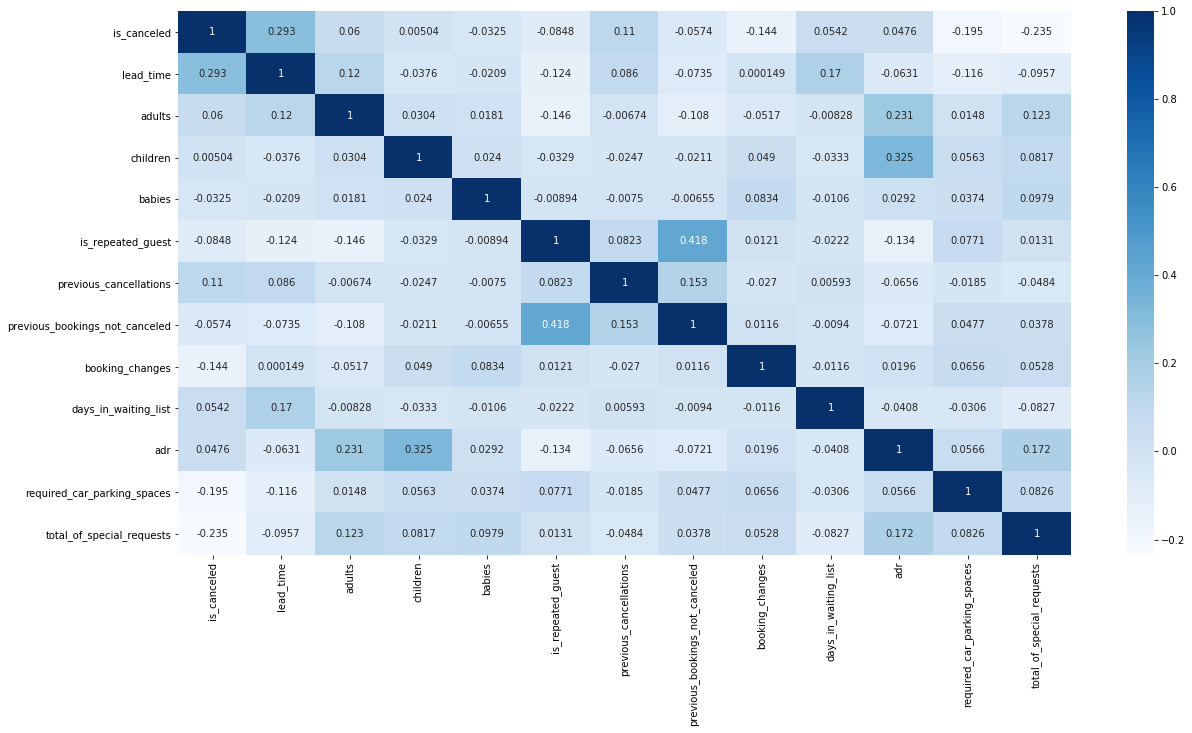

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = hotel[numeric_cols]
corr = numeric_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.3g')

### lead_time 변수

In [29]:
# lead_time 이상치 파악
# lead_time 값의 종류들 살펴보기 -> 의외로 몇백일 단위의 값들이 많다.. 이상치 제거할 필요보단 정규화시켜주어야 할 듯 싶다.
hotel['lead_time'].unique()

array([342, 737,   7,  13,  14,   0,   9,  85,  75,  23,  35,  68,  18,
        37,  12,  72, 127,  78,  48,  60,  77,  99, 118,  95,  96,  69,
        45,  40,  15,  36,  43,  70,  16, 107,  47, 113,  90,  50,  93,
        76,   3,   1,  10,   5,  17,  51,  71,  63,  62, 101,   2,  81,
       368, 364, 324,  79,  21, 109, 102,   4,  98,  92,  26,  73, 115,
        86,  52,  29,  30,  33,  32,   8, 100,  44,  80,  97,  64,  39,
        34,  27,  82,  94, 110, 111,  84,  66, 104,  28, 258, 112,  65,
        67,  55,  88,  54, 292,  83, 105, 280, 394,  24, 103, 366, 249,
        22,  91,  11, 108, 106,  31,  87,  41, 304, 117,  59,  53,  58,
       116,  42, 321,  38,  56,  49, 317,   6,  57,  19,  25, 315, 123,
        46,  89,  61, 312, 299, 130,  74, 298, 119,  20, 286, 136, 129,
       124, 327, 131, 460, 140, 114, 139, 122, 137, 126, 120, 128, 135,
       150, 143, 151, 132, 125, 157, 147, 138, 156, 164, 346, 159, 160,
       161, 333, 381, 149, 154, 297, 163, 314, 155, 323, 340, 35

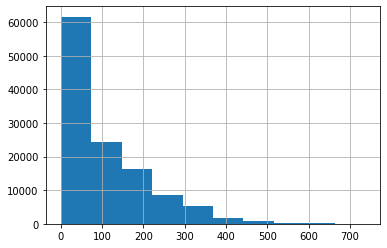

In [30]:
# 값들 분포 확인하기
hotel['lead_time'].hist()

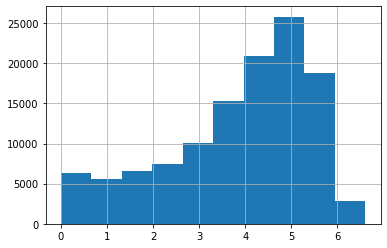

In [31]:
# +1한다음 log를 이용해 정규분포화시키기
np.log1p(hotel['lead_time']).hist()

- lead_time 은 log1p를 이용해서 분포를 변환해주자

### adults, children, babies 변수

- 기본적으로 위 3가지 변수는 종속변수(취소여부)와 상관계수가 매우 낮다. 
    * adults : 0.06
    * children : 0.00504
    * babies : -0.03
- 따라서 위 3가지 변수와 예약취소여부와의 관계는 선형관계가 아니다.

In [26]:
# adult변수 원본 분포형태 보기
hotel['adults'].value_counts()

2     89680
1     23027
3      6202
0       403
4        62
26        5
27        2
20        2
5         2
55        1
50        1
40        1
10        1
6         1
Name: adults, dtype: int64

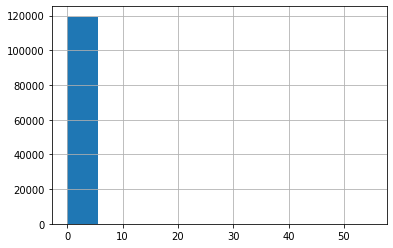

In [25]:
hotel['adults'].hist()

0.0     110800
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


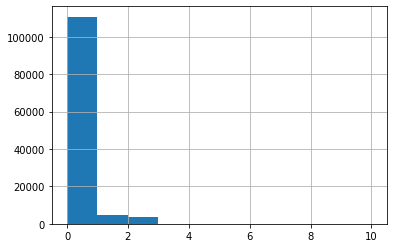

In [41]:
# children 변수
print(hotel['children'].value_counts())
print(hotel['children'].hist())

0     118473
1        900
2         15
10         1
9          1
Name: babies, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


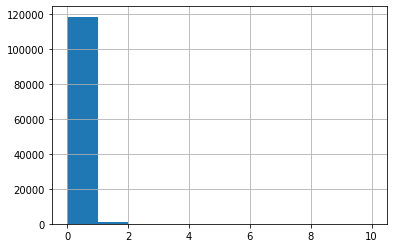

In [42]:
# babies 변수
print(hotel['babies'].value_counts())
print(hotel['babies'].hist())

- **종속변수와 선형관계를 보이지 않을 뿐더러 독립변수 값들의 분포가 한 값에 매우 몰려있기 때문에 해당 변수들을 예측 모델의 feature로서는 적합하지 않다고 판단**

### is_repeated_guest

- 해당 변수는 범주형 변수이다
    * 0이면 최초 손님
    * 1이면 중복 손님(이전에 예약한 경험이 있는 손님)

In [44]:
hotel['is_repeated_guest'].value_counts()

0    115580
1      3810
Name: is_repeated_guest, dtype: int64

- 이 변수는 그대로 레이블인코딩 상태로 feature에 넣자

### previous_cancellations

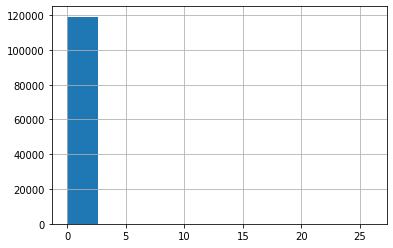

In [45]:
hotel['previous_cancellations'].hist()

In [46]:
hotel['previous_cancellations'].value_counts()

0     112906
1       6051
2        116
3         65
24        48
11        35
4         31
26        26
25        25
6         22
19        19
5         19
14        14
13        12
21         1
Name: previous_cancellations, dtype: int64

In [50]:
# 이상치라고 판단되는 value가 7이상인 데이터들은 예약을 모두 취소한 건수들일까?
hotel.loc[hotel['previous_cancellations'] > 6, 'is_canceled'].value_counts()

1    154
0     26
Name: is_canceled, dtype: int64

- 종속변수와의 상관계수값은 0.11이다.
- 이상치로 판단되는 값들의 예약취소여부를 조사해보니 그래도 이상치에 해당하는 값들이 예약 취소건수가 많았다. 따라서 이상치를 제거할 순 없다고 판단.
- 이상치가 있긴 하지만 제거하지 않고 이상치에 민감하지 않는 Robust scaler를 사용하자.

### previous_bookings_not_canceled

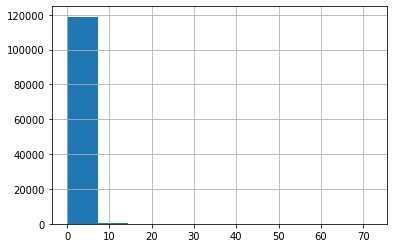

In [47]:
hotel['previous_bookings_not_canceled'].hist()

In [60]:
pd.options.display.max_rows=200
hotel['previous_bookings_not_canceled'].value_counts()

0     115770
1       1542
2        580
3        333
4        229
5        181
6        115
7         88
8         70
9         60
10        53
11        43
12        37
13        30
14        28
15        21
16        20
25        17
17        16
18        14
19        13
20        12
21        12
22        10
24         9
27         9
23         7
26         7
28         7
29         6
30         4
44         2
48         2
31         2
32         2
58         2
57         1
70         1
55         1
56         1
69         1
71         1
54         1
59         1
68         1
67         1
53         1
66         1
60         1
65         1
61         1
64         1
72         1
37         1
52         1
41         1
35         1
34         1
33         1
62         1
38         1
39         1
40         1
42         1
51         1
43         1
45         1
46         1
47         1
36         1
49         1
50         1
63         1
Name: previous_bookings_not_canceled, dtype: int64

In [54]:
hotel.loc[hotel['previous_bookings_not_canceled'] == 0, 'is_canceled'].value_counts()

0    71746
1    44024
Name: is_canceled, dtype: int64

In [53]:
# 이상치로 판단되는 1값이상의 데이터들의 예약건수 취소여부를 살펴보자
hotel.loc[hotel['previous_bookings_not_canceled'] > 0, 'is_canceled'].value_counts()

0    3420
1     200
Name: is_canceled, dtype: int64

- 종속변수와의 상관계수값은 -0.05이다.
- 확실히 이전에 취소하지 않은 예약건수들이 많을 수록 예약을 취소하지 않을 가능성이 높았다.
- 이상치가 있긴 하지만 개수가 거의 없다제거하지 않고 이상치에 민감하지 않는 Robust scaler를 사용하자.

### booking_changes

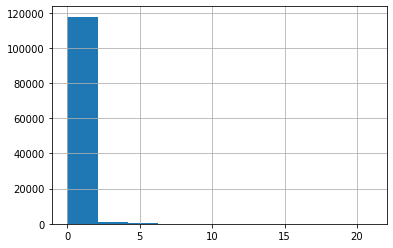

In [55]:
hotel['booking_changes'].hist()

In [56]:
hotel['booking_changes'].value_counts()

0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
13         5
14         5
15         3
11         2
12         2
16         2
17         2
20         1
18         1
21         1
Name: booking_changes, dtype: int64

In [57]:
print(hotel.loc[hotel['booking_changes'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['booking_changes'] == 0, 'is_canceled'].value_counts())

0    15243
1     2833
Name: is_canceled, dtype: int64
0    59923
1    41391
Name: is_canceled, dtype: int64


- 예약변경을 한 번도 하지 않은 사람들 중에서 예약 취소 여부 비율은 비슷했다.
- 예약변경을 한번 이상한 사람들 중에서는 예약 취소하지 않는 비율이 많았다.
- 따라서, 예약변경을 그래도 많이할수록 예약을 취소하지 않는다.
- 그러므로 이상치를 제거하는 것보다 이상치에 민감하지 않은 Robust scaler를 사용해야 할 듯 하다.

### days_in_waiting_list

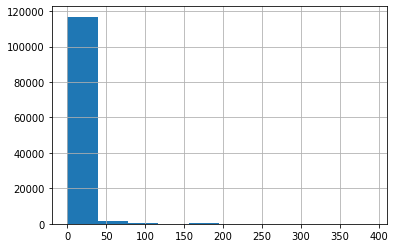

In [58]:
hotel['days_in_waiting_list'].hist()

In [61]:
hotel['days_in_waiting_list'].value_counts()

0      115692
39        227
58        164
44        141
31        127
35         96
46         94
69         89
63         83
50         80
87         80
38         76
111        71
45         65
101        65
77         63
41         63
223        61
62         60
3          59
98         59
22         56
122        55
15         54
48         52
176        50
91         50
28         50
17         47
96         46
187        45
56         45
391        45
68         42
60         41
75         40
93         40
21         37
236        35
65         35
147        30
33         30
19         30
162        30
178        30
42         30
20         29
10         28
40         28
27         26
34         26
120        25
4          25
57         25
160        25
25         25
80         24
47         24
215        21
79         20
108        20
24         19
99         19
32         19
43         19
174        19
70         18
61         18
49         18
9          16
125        16
6     

In [62]:
# 예약이 확정될 때까지 하루이상걸린 예약건수들의 취소 여부비율 살펴보기
print(hotel.loc[hotel['days_in_waiting_list'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['days_in_waiting_list'] == 0, 'is_canceled'].value_counts())

1    2359
0    1339
Name: is_canceled, dtype: int64
0    73827
1    41865
Name: is_canceled, dtype: int64


- 예약을 확정짓는데 하루 이상 걸린 사람들은 예약취소하는 경향이 있는 듯하다.
- 이상치를 제거하지 않고 Robust scaler사용

### required_car_parking_spaces

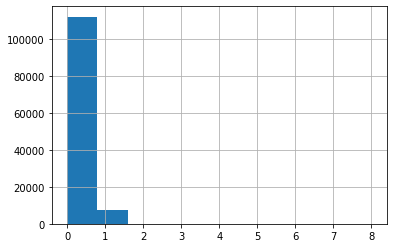

In [63]:
hotel['required_car_parking_spaces'].hist()

In [64]:
hotel['required_car_parking_spaces'].value_counts()

0    111974
1      7383
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

In [65]:
# 주차공간을 요구하는 사람들은 예약을 취소할까?
print(hotel.loc[hotel['required_car_parking_spaces'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['required_car_parking_spaces'] == 0, 'is_canceled'].value_counts())

0    7416
Name: is_canceled, dtype: int64
0    67750
1    44224
Name: is_canceled, dtype: int64


- 주차공간을 요구한 사람들은 무조건 예약을 취소하지 않는다.
- 따라서 이상치를 제거하지 않고 Robust Scaler적용

### total_of_special_requests

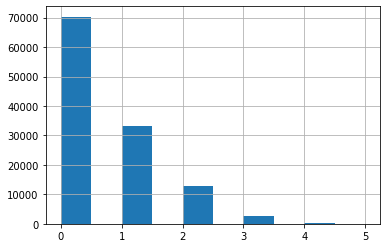

In [66]:
hotel['total_of_special_requests'].hist()

In [67]:
hotel['total_of_special_requests'].value_counts()

0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: total_of_special_requests, dtype: int64

In [69]:
# 이상치로 판단되는 4,5 일때 예약취소여부를 살펴보자
print(hotel.loc[hotel['total_of_special_requests'] > 3, 'is_canceled'].value_counts())
print(hotel.loc[hotel['total_of_special_requests'] == 3, 'is_canceled'].value_counts())

0    342
1     38
Name: is_canceled, dtype: int64
0    2051
1     446
Name: is_canceled, dtype: int64


- 호텔에 특별요구(방 종류 변경, 고층실 예약 요구)를 많이 한사람들은 예약을 취소하지 않는 경향이 강하다
- 따라서 이상치를 제거하지 않고 Robust scaler적용

## Feature Engineering 

* Target variable(binary) : is_canceled
* Numeric variables 
    - 예약날짜 관련 함수는 모두 삭제
    - lead_time : log1p변환
    - 어른,아이,아기 변수 삭제
    - is_repeated_guest는 현재상태 유지(레이블 인코딩)

In [74]:
# adr 변수 삭제
numeric_cols.tolist().remove('adr')
print(numeric_cols)

['is_canceled' 'lead_time' 'adults' 'children' 'babies'
 'is_repeated_guest' 'previous_cancellations'
 'previous_bookings_not_canceled' 'booking_changes' 'days_in_waiting_list'
 'adr' 'required_car_parking_spaces' 'total_of_special_requests']


In [78]:
final_cols = numeric_cols.tolist()
extra_cols = ['stays_in_weekend_nights','stays_in_week_nights']
for col in extra_cols:
    final_cols.append(col)
print(final_cols)

['is_canceled', 'lead_time', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'stays_in_weekend_nights', 'stays_in_week_nights']


### Categorical Variable encoding

In [81]:
category_cols = ['hotel','meal','market_segment','distribution_channel','reserved_room_type','assigned_room_type',
                'deposit_type','customer_type','reservation_status']
category_df = hotel[category_cols]
category_df.columns

Index(['hotel', 'meal', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'deposit_type',
       'customer_type', 'reservation_status'],
      dtype='object')

In [83]:
# reservation_status는 예약 취소여부 후 나오는 변수값으로 해당 변수는 순차적으로 예약취소여부가 나온 후에 도출되는 변수므로 삭제
del category_df['reservation_status']

In [89]:
# 예약한 방 유형에 따라 취소 여부 관계 살펴보기
hotel.groupby(['reserved_room_type','is_canceled']).agg({'hotel':'count'})

hotel
reserved_room_type is_canceled       
A                  0            52364
                   1            33630
B                  0              750
                   1              368
C                  0              624
                   1              308
D                  0            13099
                   1             6102
E                  0             4621
                   1             1914
F                  0             2017
                   1              880
G                  0             1331
                   1              763
H                  0              356
                   1              245
L                  0                4
                   1                2
P                  1               12

In [90]:
hotel.groupby(['assigned_room_type','is_canceled']).agg({'hotel':'count'})

hotel
assigned_room_type is_canceled       
A                  0            41105
                   1            32948
B                  0             1651
                   1              512
C                  0             1929
                   1              446
D                  0            18960
                   1             6362
E                  0             5838
                   1             1968
F                  0             2824
                   1              927
G                  0             1773
                   1              780
H                  0              461
                   1              251
I                  0              358
                   1                5
K                  0              267
                   1               12
L                  1                1
P                  1               12

In [98]:
# 이진분류 문제이기 때문에 범주형 변수들을 원-핫 인코딩보다는 레이블 인코딩으로 변환
# 회귀분석 문제일 때는 범주형 변수를 레이블 인코딩으로 하면 레이블 간의 순서 차이값들이 예측값에 영향미침 -> 그렇다면 로지스틱회귀분석을 사용하면 안되지 않을까?
from sklearn.preprocessing import LabelEncoder

category_columns = category_df.columns.tolist()
encoders = {}

for col in category_columns:
    encoder = LabelEncoder()
    category_df[col] = encoder.fit_transform(category_df[col])
    encoders[col] = encoder

/Users/younghun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [100]:
category_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,1,0,3,1,2,2,0,2
1,1,0,3,1,2,2,0,2
2,1,0,3,1,0,2,0,2
3,1,0,2,0,0,0,0,2
4,1,0,6,3,0,0,0,2


### Numeric Variable encoding

In [103]:
# lead_time에 로그 취해주기
numeric_df['lead_time'] = np.log1p(numeric_df['lead_time'])

/Users/younghun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
# is_canceled(종속변수)와 lead_time변수 제외하고 모두 Robust Scaler 적용
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numeric_df.iloc[:,2:] = scaler.fit_transform(numeric_df.iloc[:,2:])
numeric_df.head()

,is_canceled,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,5.837730,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-1.667695,0.0,0.0
1,0,6.603944,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,-1.667695,0.0,0.0
2,0,2.079442,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.345177,0.0,0.0
3,0,2.639057,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.345177,0.0,0.0
4,0,2.708050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060395,0.0,1.0


In [106]:
# adr 변수 삭제
del numeric_df['adr']

In [107]:
numeric_df.head()

,is_canceled,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,0,5.837730,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1,0,6.603944,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,0,2.079442,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2.639057,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2.708050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### merge categorical and numeric variables

In [109]:
print("범주형 변수 데이터프레임:", category_df.shape)
print("수치형 변수 데이터프레임:", numeric_df.shape)

범주형 변수 데이터프레임: (119390, 8)
수치형 변수 데이터프레임: (119390, 12)


In [111]:
final_data = pd.concat([category_df, numeric_df], axis=1)
final_data.shape

(119390, 20)

## Modeling

- 많은 범주형 변수의 레이블 인코딩으로 회귀식을 가정한 머신러닝 모델 사용은 지양
- 이진분류 문제
    * SVM
    * Ensemble
    * ANN

### Ensemble
- RandomForest
- Light GBM
- 또?